In [ ]:
#| hide
#| default_exp xscale
from nbdev import *

# Amplitude correction extraction

> This module provides a way to extract amplitude correction matrix from the eta calculation data generated by the `estimate_width_scale` method.

In [ ]:
#| exporti

import numpy as np
from scipy.special import expit
from scipy.stats import chi2, chi, norm

import ase
import ase.units as un
from ase.calculators.vasp import Vasp
import spglib
from spglib import find_primitive, get_symmetry_dataset
from glob import glob
from matplotlib import pyplot as plt
from hecss.util import normalize_conf
from hecss.monitor import plot_hist
from hecss import *

## LAMPS data on olivine

In [ ]:
#| export

def plot_virial_stat(cryst, smpl, normal=True):
    elems = cryst.get_chemical_symbols()
    elmap = cryst.get_atomic_numbers()
    vir = np.array([abs(s[2]*s[3]) for s in smpl])
    vir /= vir.mean(axis=(-1,-2))[:,None,None]
    nat = len(elems)
    xscale = np.ones(cryst.get_positions().shape)
    # m, s = plot_hist(vir.mean(axis=(-1,-2)), 'Total', 0, normal=True)
    mi = 1
    ma = 1
    for n, el in enumerate(sorted(set(elems))):
        elmask = np.array(elems)==el
        m, s = plot_hist(1/np.sqrt(vir[:, elmask, :].mean(axis=(-1,-2))), 
                         el, n+1, normal=normal, df=3*sum(elmask))
        if mi > m-3*s:
            mi = m-3*s
        if ma < m+3*s:
            ma = m+3*s
        xscale[elmask] = m
    plt.axvline(1, ls=':', color='C5', label='Equilibrium')
    plt.xlim(mi, ma)
    plt.legend()
    plt.title('Normalized Virial distribution in the sample')
    plt.ylabel('Probability density')
    plt.xlabel('Normalized Virial');
    return xscale

In [ ]:
#| asap
from hecss.monitor import plot_stats, plot_xs_stat
from hecss.monitor import plot_acceptance_history, plot_dofmu_stat
from hecss.util import select_asap_model, create_asap_calculator, calc_init_xscale
from tqdm.auto import tqdm

In [ ]:
#| asap
model = select_asap_model('Universal')
print(f'Using potential model: {model}')

oliv = ase.io.read('data/spinel.POSCAR')
oliv.set_calculator(create_asap_calculator(model))
print(f'Space group: {spglib.get_spacegroup(oliv)}')

Using potential model: LJ_ElliottAkerson_2015_Universal__MO_959249795837_003
Space group: Fd-3m (227)


In [ ]:
#| asap
N = 100

sampler = HECSS(oliv, lambda : create_asap_calculator(model))
m, s, xscl = sampler.estimate_width_scale(N, Tmax=1000)

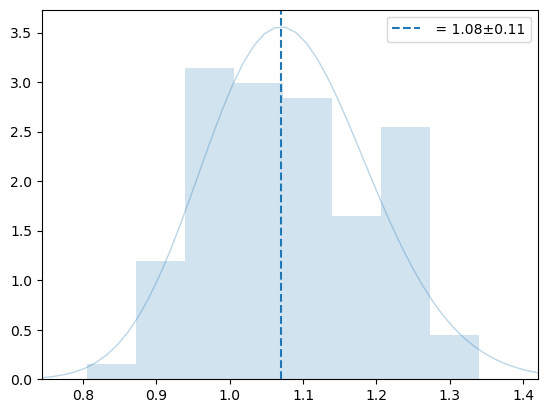

In [ ]:
#| asap
wm = np.array(sampler._eta_list).T
y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
plot_hist(y, '', 0, normal=False, df=3*len(oliv))
plt.legend()
plt.show()

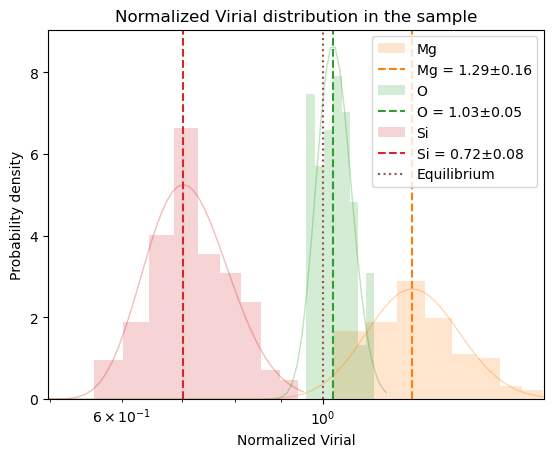

In [ ]:
#| asap
plt.semilogx()
plot_virial_stat(oliv, sampler._eta_samples, normal=False);

In [ ]:
#| asap
T = 600
N = 1_000
dofmu = []
xsl = []
sampler.xscale_init = xscl.copy()
osamples = sampler.sample(T, N, dofmu_list=dofmu, xscale_list=xsl)
# osamples = [s for s in tqdm(sampler._sampler(T, N, 
#                                             dofmu_list=dofmu, xscale_list=xsl), total=N)]

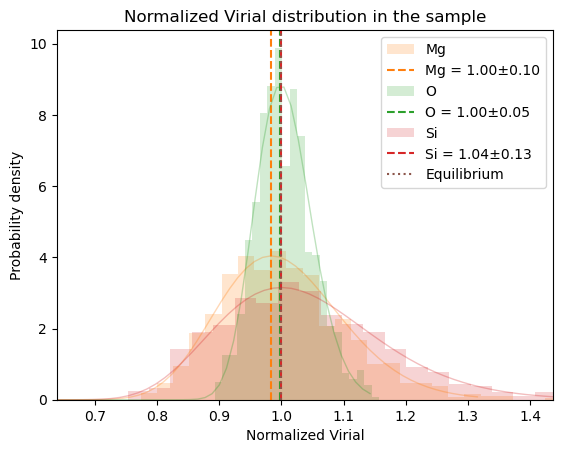

In [ ]:
#| asap
plot_virial_stat(oliv, osamples, normal=False);

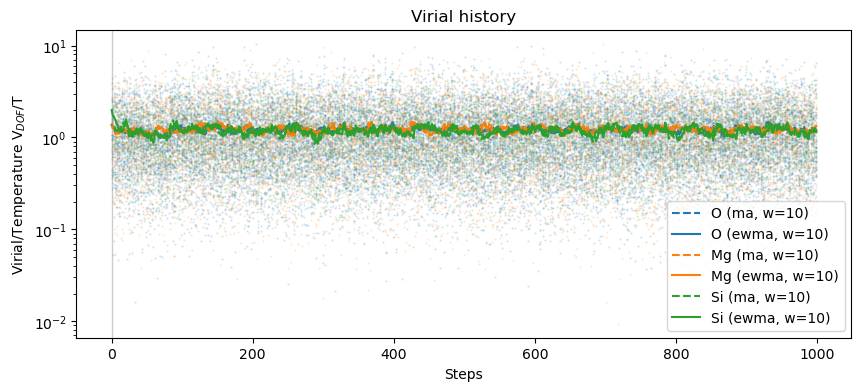

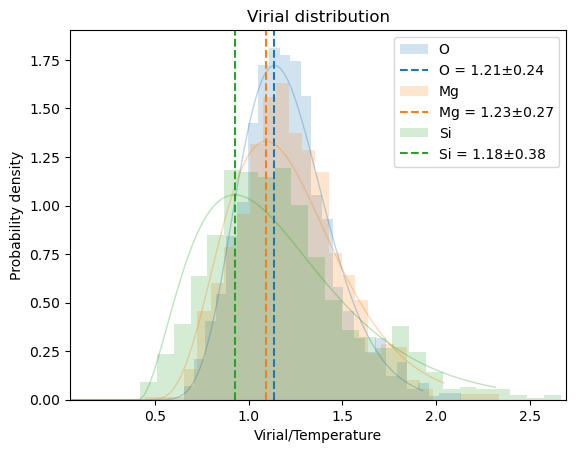

In [ ]:
#| asap
plot_dofmu_stat(oliv, dofmu, skip=0, window=10)

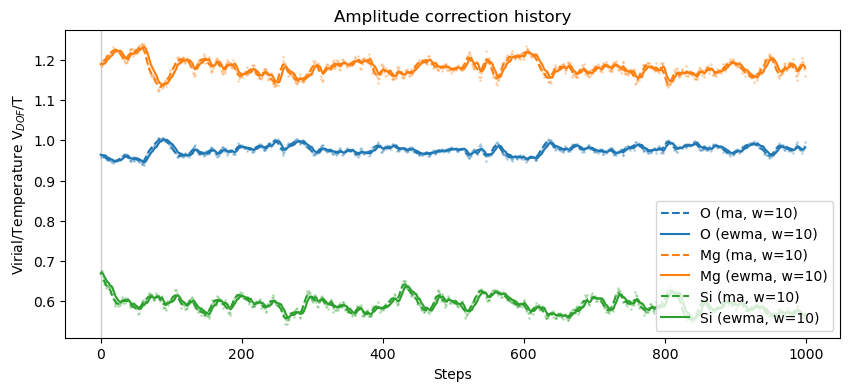

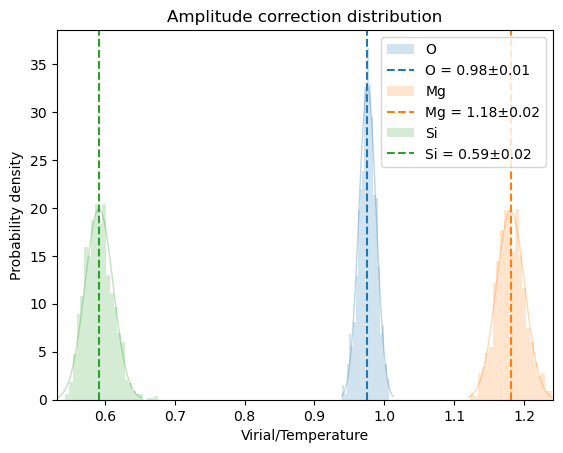

In [ ]:
#| asap
plot_xs_stat(oliv, xsl, skip=0, window=10)

## VASP calculations

> Here we use pre-calculated vasp data for 3C-SiC 2x2x2 suprecell

In [ ]:
# Use more realistic pre-calculated data 
supercell = '2x2x2'

In [ ]:
sc = ase.io.read(f'example/VASP_3C-SiC/{supercell}/sc_{supercell}/vasprun.xml')

In [ ]:
e0 = sc.get_potential_energy()

In [ ]:
eqdelta=0.05
eqsigma=0.2

nat = len(sc)
dim = (nat, 3)
symprec=1e-5
symm = get_symmetry_dataset(sc, symprec=symprec)
dofmap = symm['mapping_to_primitive']
dof = list(sorted(set(dofmap)))
dofmu = np.ones((len(dof), 3))
mu = np.ones(dim)

In [ ]:
xscale = np.ones(dim)
dofxs = np.array([xscale[dofmap==d,:].mean(axis=0) for d in dof])
vt = []

# for i, sfn in enumerate(sorted(glob(f'TMP/calc_{supercell}/w_est/*/vasprun.xml'))):
for i, sfn in enumerate(sorted(glob(f'example/VASP_3C-SiC_calculated/calc_{supercell}/w_est/*/vasprun.xml'))):
    s = ase.io.read(sfn)
    dx = normalize_conf(s, sc)[0] - sc.get_positions()
    try :
        f = s.get_forces()
        e = (s.get_potential_energy() - e0)/nat
        v = np.abs(dx*f)
        v = dx*f
        v /= v.mean()
        dofv = np.array([v[dofmap==d,:].mean(axis=0) for d in dof])
        # dofxs *= (1-2*eqdelta*(expit((np.sqrt(dofmu)-1)/eqsigma)-0.5))
        # dofxs /= np.sqrt((dofxs**2).mean())
        vt.append(dofv.reshape(-1))
    except RuntimeError:
        continue

vt = np.array(vt).reshape(-1,2,3)
vta = vt.reshape(-1,2,3).mean(axis=-1)
mu = vta.cumsum(axis=0)
mu /= np.arange(1,len(mu)+1)[:, None]

array([1.01036281, 0.98963719])

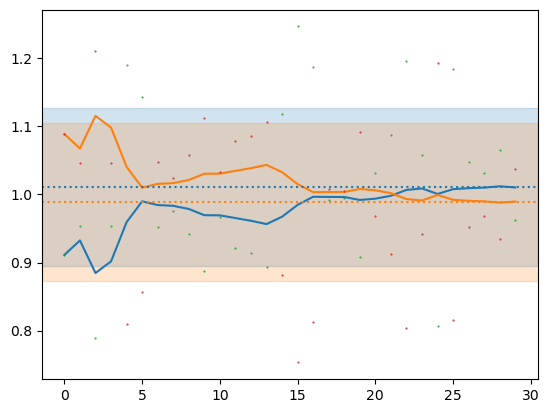

In [ ]:
# plt.semilogy()
plt.plot(mu, '-')
plt.plot(vta, '.', ms=1)
for dofn in 0, 1:
    m = vta[:,dofn].mean()
    s = vta[:,dofn].std()
    plt.axhline(m, ls=':', color=f'C{dofn}')
    plt.axhspan(m-s, m+s, color=f'C{dofn}', alpha=0.2)
mu[-1]

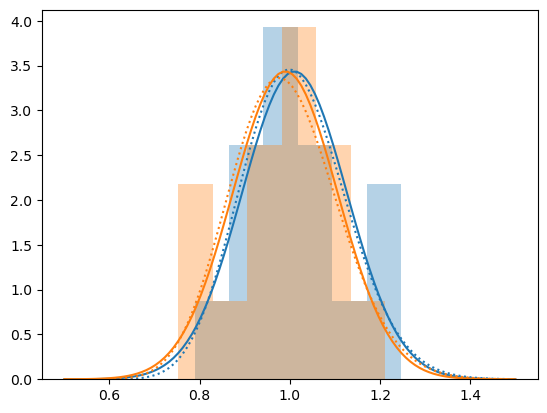

In [ ]:
x=np.linspace(0.5,1.5,100)
for dofn in 0, 1:
    rv = vt[:,dofn,:].mean(axis=-1).reshape(-1)
    plt.hist(rv, density=True, bins='auto',
             color=f'C{dofn}', alpha=0.33, label=f'{dofn}')
    fit = chi.fit(rv, f0=12)
    plt.plot(x, chi.pdf(x, *fit), ls=':', color=f'C{dofn}')
    fit = norm.fit(rv)
    plt.plot(x, norm.pdf(x, *fit), ls='-', color=f'C{dofn}')